# «Модель прогнозирования стоимости жилья для агентства недвижимости»

### ПОСТАНОВКА ЗАДАЧИ

Агентство недвижимости столкнулось с проблемой — риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.

Типовая задача из области Data Science, основанная на данных о недвижимости в США.

**Бизнес-задача:** улучшить финансовые показатели компании за счет уменьшения времени на обработку информации о недвижимости у риелторов.

**Техническая задача для вас как для специалиста в Data Science:** разработать модель машинного обучения, которая поможет обрабатывать объявления и увеличит число сделок и прибыль агентства.

**Основные цели проекта:**
1. Провести разведывательный анализ и очистку исходных данных.
2. Выделить наиболее значимые факторы, влияющие на стоимость недвижимости.
3. Построить модель для прогнозирования стоимости недвижимости.
4. Разработать небольшой веб-сервис, на вход которому поступают данные о некоторой выставленной на продажу недвижимости, а сервис прогнозирует его стоимость.

In [37]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway, kruskal
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree,  ensemble
from catboost import Pool, CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import category_encoders as ce

In [38]:
#прочитаем данные из файла
r = pd.read_csv('eda_data.csv', sep = ',')

In [39]:
#проверим, что данные выгрузились корректно, для этого выведем первые две строки датафрейма
r.head()

,baths,sqft,sch_rating,property_age,capital_state,status_new,status_pending,status_foreclosure,type_single_1,type_single_2,...,state_1,state_2,state_3,state_4,state_5,city_4,city_5,city_10,target,log_target
0,3.50,2900.0,5.0,4.0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,418000.0,12.943239
1,3.00,1947.0,4.0,4.0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,310000.0,12.644331
2,2.00,3000.0,6.0,56.0,0,0,0,0,1,0,...,0,0,0,1,1,0,0,1,2895000.0,14.878496
3,3.00,897.0,2.0,103.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,209000.0,12.250094
4,2.25,1507.0,2.0,17.0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,181500.0,12.109016


In [40]:
#проверим все ли признаки на месте
r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322871 entries, 0 to 322870
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   baths               322871 non-null  float64
 1   sqft                322871 non-null  float64
 2   sch_rating          322871 non-null  float64
 3   property_age        322871 non-null  float64
 4   capital_state       322871 non-null  int64  
 5   status_new          322871 non-null  int64  
 6   status_pending      322871 non-null  int64  
 7   status_foreclosure  322871 non-null  int64  
 8   type_single_1       322871 non-null  int64  
 9   type_single_2       322871 non-null  int64  
 10  type_apartment      322871 non-null  int64  
 11  type_multi          322871 non-null  int64  
 12  type_single_3       322871 non-null  int64  
 13  type_condo          322871 non-null  int64  
 14  type_not_land       322871 non-null  int64  
 15  type_mobile         322871 non-nul

Итак, у нас в распоряжении осталось 322871 наблюдений, 24 - предиктора, целевая переменная и целевая логарифмированная переменная.

На прошлом этапе мы уже определились с типом валидации - hold-out-валидация и разделили выборку на тестовую и валидационную в соотношении 80/20.

Повторим эти шаги.

In [41]:
#сформируем матрицу наблюдений X
X = r.drop(['target', 'log_target'], axis=1)
# вектор целевой переменной y 
y = r['target']
# и его логарифм y_log
y_log = r['log_target']

#разобьем выборку на обучающую и валидационную в соотношении 80/20
X_train, X_valid, y_train_log, y_valid_log = model_selection\
    .train_test_split(X, y_log, test_size=0.20, random_state=42)

In [42]:
#посмотрим сколько наблюдений у нас попало в каждую из выборок
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (258296, 24)
Valid shape: (64575, 24)


Итак, 258296 объектов недвижимости являются обучающими — в них модель будет искать закономерности и подбирать внутренние параметры, а 64575 являются валидационными — на них мы будем производить контроль качества.

In [43]:
# нормализуем предикторы в обучающей и валидационной выборках с помощью MinMaxScaler
#инициализируем нормализатор MinMaxScaler
scaler = preprocessing.MinMaxScaler()
#нормализуем обучающую выборку и поместим ее в таблицу
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
#нормализуем валидационную выборку и поместим ее в таблицу
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)

Для построения модели прогнозирования будем использовать модели регрессии, так как нам необходимо спрогнозировать числовой признак.

Заранее создадим функцию, которая будет расчитывать метрики:

1. MAE - средняя абсолютная ошибка (целевая метрика)
2. MAPE - средняя абсолютная ошибка в процентах 
3. $R^2$ - коэффициент детерминации

In [44]:
def print_metrics(y_train_log, y_train_log_pred, y_valid_log, y_valid_log_pred):
    print('Train R^2: {:.2f}'.format(metrics.r2_score(y_train_log, y_train_log_pred)))
    print('Train MAE: {:.2f}'.format(metrics.mean_absolute_error(y_train_log, y_train_log_pred)))
    print('Train MAPE: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_train_log, y_train_log_pred)*100))
    print('Train MSE: {:.2f}'.format(metrics.mean_squared_error(y_train_log, y_train_log_pred)))
    print('\n')
    print('Valid R^2: {:.2f}'.format(metrics.r2_score(y_valid_log, y_valid_log_pred)))
    print('Valid MAE: {:.2f}'.format(metrics.mean_absolute_error(y_valid_log, y_valid_log_pred)))
    print('Valid MAPE: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_valid_log, y_valid_log_pred)*100))
    print('Train MSE: {:.2f}'.format(metrics.mean_squared_error(y_valid_log, y_valid_log_pred)))

### Модель линейной регрессии (LinearRegression)

In [45]:
# построим модель линейной регрессии на обучающей выборке
# создаем объект класса LinearRegression
lr = linear_model.LinearRegression()
#обучение модели на тренировочной выборке
lr.fit(X_train_scaled, y_train_log)
#предсказываем целевой признак на тренировочной и валидационной выборках
y_train_log_pred = lr.predict(X_train_scaled)
y_valid_log_pred = lr.predict(X_valid_scaled)

print_metrics(y_train_log, y_train_log_pred,y_valid_log, y_valid_log_pred)

Train R^2: 0.50
Train MAE: 0.47
Train MAPE: 3.68
Train MSE: 0.39


Valid R^2: 0.50
Valid MAE: 0.47
Valid MAPE: 3.68
Train MSE: 0.39


Оценки на валидационной и обучающей выборке приблизительно одинаковые. Коэффициент детерминации ниже равен 0.5 говорит об удовлетворительном качестве модели. Близкие по значению коэффициенты детерминации на валидационной и обучающей выборках свидетельствуют об отсутствии переобучения модели.

В среднем значения на тренировочной и тестовой выборках отличаются на 0.47 об этом свидетельствует средняя абсолютная ошибка(MAE). Это 3.68 % (MAPE) того, на сколько в среднем отклоняется предсказание от реальных значений.

### Модель дерева решений (DecisionTreeRegressor)

Как известно качество модели дерева решений зависит от его глубины. Попробуем определить оптимальную глубину дерева решений для наших данных.

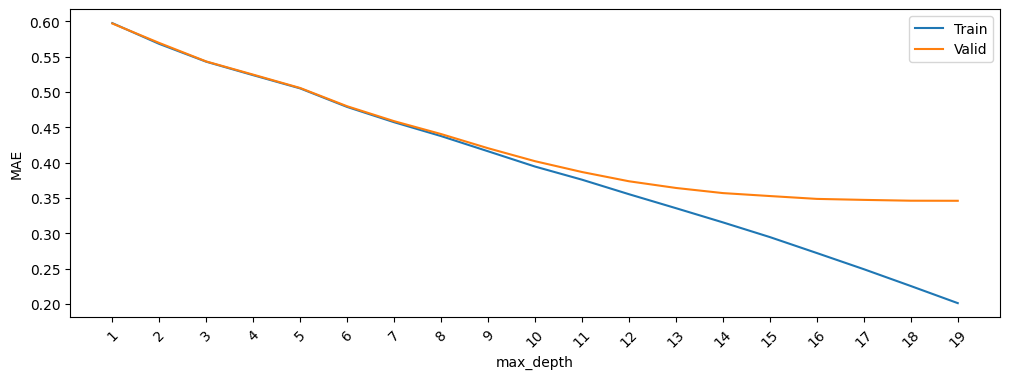

In [46]:
#подберем max_depth
#Создаем список из возможных значений от 1 до 20 с шагом 1
max_depth_list = range(1,20,1)
#Создаем пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []
for depth in max_depth_list:
    #Создаем объект класса деверья решений DecisionTreeRegressor
    dt_model = tree.DecisionTreeRegressor(max_depth=depth, random_state= 42)
    #Обучаем модель предсказывать логарифм целевого признака
    dt_model.fit(X_train_scaled, y_train_log)
    #Делаем предсказание для каждой из выборок
    y_train_log_pred = dt_model.predict(X_train_scaled)
    y_valid_log_pred = dt_model.predict(X_valid_scaled)
    #Рассчитываем метрику для двух выборок и добавляем их в списки
    train_scores.append(metrics.mean_absolute_error(y_train_log, y_train_log_pred))
    test_scores.append(metrics.mean_absolute_error(y_valid_log, y_valid_log_pred))

#Визуализируем изменение MAE в зависимости от max_depth
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(max_depth_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(max_depth_list, test_scores, label='Valid') #линейный график для тестовой выборки
ax.set_xlabel('max_depth') #название оси абсцисс
ax.set_ylabel('MAE') #название оси ординат
ax.set_xticks(max_depth_list) #метки по оси абцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды

In [47]:
# построим модель дерева решений на обучающей выборке
# создаем объект класса DecisionTreeRegressor
dt_model = tree.DecisionTreeRegressor(random_state=42,
                                      max_depth=8)
#обучаем модель на тренировочной выборке
dt_model.fit(X_train_scaled, y_train_log)

#предсказываем целевую переменную на обучающей и валидационной выборках
y_train_log_pred = dt_model.predict(X_train_scaled)
y_valid_log_pred = dt_model.predict(X_valid_scaled)
#выводим метрики
print_metrics(y_train_log, y_train_log_pred,y_valid_log, y_valid_log_pred)

Train R^2: 0.54
Train MAE: 0.44
Train MAPE: 3.45
Train MSE: 0.35


Valid R^2: 0.54
Valid MAE: 0.44
Valid MAPE: 3.47
Train MSE: 0.36


Модель дерева решений на наших данных работает немного лучше. Коэффициент детерминации подрос на 0.04. И теперь модель описывает 54 % данных. Так как коэффициент детерминации больше 0.5, модель можно считать удовлетворительной. Равенство коэффициентов детерминации тестовой и валидационной выборок говорит о том, что переобучение отсутствует.

### Модель случайного леса (RandomForestRegressor)

Попробуем усилить нашу модель, построим модель случайного леса, но прежде подберем оптимальные гиперпараметры модели с помощью метода RandomizedSearchCV.

In [48]:
# Создаем сетку перебираемых параметров
param_distributions = {'n_estimators': [100, 150, 200],
                       'max_depth': np.arange(11, 18, 2),
                       'min_samples_leaf': [5, 10, 15]}

# Создаем модель RandomizedSearchCV
rand_search = model_selection.RandomizedSearchCV(estimator = ensemble.RandomForestRegressor(
                                                               n_jobs = -1,
                                                               warm_start = True,
                                                               random_state = 42),
                                                 param_distributions = param_distributions,
                                                 cv = 2,
                                                 scoring = 'r2',
                                                 return_train_score = False,
                                                 n_jobs = -1,
                                                 verbose = 1)

# Обучим модель
rand_search.fit(X_train_scaled, y_train_log)

# Сделаем предсказания
y_train_pred = rand_search.predict(X_train_scaled)
y_valid_pred = rand_search.predict(X_valid_scaled)

print_metrics(y_train_log, y_train_log_pred,y_valid_log, y_valid_log_pred)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Train R^2: 0.54
Train MAE: 0.44
Train MAPE: 3.45
Train MSE: 0.35


Valid R^2: 0.54
Valid MAE: 0.44
Valid MAPE: 3.47
Train MSE: 0.36


In [49]:
# Выведем подобранные значения гиперпараметров, использованные для прогноза
print('Наилучшие значения гиперпараметров:', rand_search.best_params_)

Наилучшие значения гиперпараметров: {'n_estimators': 100, 'min_samples_leaf': 5, 'max_depth': 17}


Более сложная модель, но по сравнению с деревом решений метрики не улучшились.

### Градиентный бустинг над деревьями решений (GradientBoostingRegressor)

Попробуем еще больше усилить модель и найти для  нее метрики.

In [50]:
# Строим модель градиентного бустинга
gb_reg = ensemble.GradientBoostingRegressor(learning_rate = 0.5,
                                            n_estimators = 100,
                                            max_depth = 6,
                                            min_samples_split = 30,
                                            random_state = 42)

# Обучаем модель
gb_reg.fit(X_train_scaled, y_train_log)

# Выполняем предсказание
y_train_pred = gb_reg.predict(X_train_scaled)
y_valid_pred = gb_reg.predict(X_valid_scaled)

print_metrics(y_train_log, y_train_log_pred,y_valid_log, y_valid_log_pred)

Train R^2: 0.54
Train MAE: 0.44
Train MAPE: 3.45
Train MSE: 0.35


Valid R^2: 0.54
Valid MAE: 0.44
Valid MAPE: 3.47
Train MSE: 0.36


И эта модель не дала качественных изменений метрик. А что если объединить эти модели в одну. На следующем этапе попробуем применить стекинг.

### Стэкинг моделей (StackingRegressor)

In [51]:
# Создаем список моделей для стекинга с подобранными ранее параметрами
estimators = [
    ('dt', tree.DecisionTreeRegressor(
           max_depth = 8,
           random_state = 42)
    ),
    ('rf', ensemble.RandomForestRegressor(
           n_estimators = 150,
           max_depth = 17,
           min_samples_leaf = 5,
           n_jobs = -1,
           warm_start = True,
           random_state = 42)
    ),
    ('gb', ensemble.GradientBoostingRegressor(
           learning_rate = 0.5,
           n_estimators = 100,
           max_depth = 6,
           min_samples_split = 30,
           random_state = 42)
    )
]

# Создаем объект класса стекинг
stack_reg = ensemble.StackingRegressor(
            estimators = estimators,
            final_estimator = ensemble.RandomForestRegressor(
                              n_estimators = 150,
                              max_depth = 17,
                              min_samples_leaf = 5,
                              n_jobs = -1,
                              warm_start = True,
                              random_state = 42),
            cv = 2,
            n_jobs = -1,
            verbose = 5
)

# Обучаем модель
stack_reg.fit(X_train_scaled, y_train_log)

# Делаем предсказание
y_train_log_pred = stack_reg.predict(X_train_scaled)
y_valid_log_pred = stack_reg.predict(X_valid_scaled)

print_metrics(y_train_log, y_train_log_pred,y_valid_log, y_valid_log_pred)

Train R^2: 0.80
Train MAE: 0.28
Train MAPE: 2.20
Train MSE: 0.16


Valid R^2: 0.74
Valid MAE: 0.31
Valid MAPE: 2.46
Train MSE: 0.20


Отличный результат, по-моему. Благодаря стекингу трех моделей у нас получилось значительно улучшить качество метрик. Коэффициент детерминации теперь описывает 80 и 74 процента выборки соответственно для обучающей выборки и валидационной выборки. Получилось улучшить и метрики отклонений.

In [52]:
#создадим словарь 
metric_dict = {'Metric': ['Train R2', 'Train MAE', 'Train MAPE', 'Train MSE',\
                        'Valid R2', 'Valid MAE', 'Valid MAPE', 'Valid MSE'],
            'LinearRegression': [0.54,0.44,3.45,0.35,0.54,0.44,3.47,0.36],
            'DecisionTreeRegressor': [0.54,0.44,3.45,0.35,0.54,0.44,3.47,0.36],
            'RandomForestRegressor': [0.54,0.44,3.45,0.35,0.54,0.44,3.47,0.36],
            'GradientBoostingRegressor':[0.54,0.44,3.45,0.35,0.54,0.44,3.47,0.36],
            'StackingRegressor': [0.80,0.28,2.20,0.16,0.74,0.31,2.46,0.20]}
#создадим сводную таблицу метрик
metric_df = pd.DataFrame(metric_dict)
metric_df

,Metric,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,StackingRegressor
0,Train R2,0.54,0.54,0.54,0.54,0.80
1,Train MAE,0.44,0.44,0.44,0.44,0.28
2,Train MAPE,3.45,3.45,3.45,3.45,2.20
3,Train MSE,0.35,0.35,0.35,0.35,0.16
4,Valid R2,0.54,0.54,0.54,0.54,0.74
5,Valid MAE,0.44,0.44,0.44,0.44,0.31
6,Valid MAPE,3.47,3.47,3.47,3.47,2.46
7,Valid MSE,0.36,0.36,0.36,0.36,0.20


На основе этой таблицы сделаем вывод, что объединение более слабых моделей дерева решений (коэффициент деретминации 0.54/0.54), случайного леса (коэффициент детерминации 0.54/0.54) и градиентного спуска (коэффициент детерминации 0.54/0.54) привело к улучшению качества модели и метрик.

Мы провели большую работу. 

Очистли и обработали данные: преобразовали данные к нужному типу, очистили данные от ненужных символов и элементов, удалили из таблицы неинформативные наблюдения содержащие больше 50 % выбросов, удалили из таблицы признаки содержащие большое число пропусков, постарались устранить пересорт в данных.

Провели разведовательный анализ: сгенерировали новые признаки, заполнили пропуски, очистили данные от выбросов, проверили зависимости и взаимосвязи между признаками, выделили 24 признака для создания модели.

Создали модель прогнозирования стоимости недвижимости с помощью StackingRegressor, объединив модели DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor.